# Baseline Models (No Graph Structure)

**Objective**: Classify nodes using only node features (no graph structure).

**Key principle**: Each node v evaluated at exactly t_first(v) + K to ensure K timesteps of observation.

In [1]:
import sys
from pathlib import Path

# Add project root to path
ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

np.random.seed(42)

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG
print(f"Train cohorts: t={CONFIG['train_timesteps'][0]} to {CONFIG['train_timesteps'][1]}")
print(f"Val cohorts:   t={CONFIG['val_timesteps'][0]} to {CONFIG['val_timesteps'][1]}")
print(f"Test cohorts:  t={CONFIG['test_timesteps'][0]} to {CONFIG['test_timesteps'][1]}")
print(f"Observation windows K: {CONFIG['observation_windows']}")

Train cohorts: t=5 to 24
Val cohorts:   t=29 to 31
Test cohorts:  t=37 to 43
Observation windows K: [0, 3, 5]


## Load Data & Create Temporal Splits

In [3]:
# Load elliptic dataset with temporal features (no leakage)
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache',
    use_cache=True,
    verbose=False
)

# Create temporal splits (non-overlapping cohorts)
split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True  # Only nodes with known labels
)

print(f"\nTrain: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")


Train: 96470 nodes
Val:   9884 nodes
Test:  39305 nodes


## Prepare Per-Node Observation Window Graphs

Each node v is evaluated at time t_first(v) + K.

In [4]:
graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=torch.device(CONFIG['device'])
)


PREPARING OBSERVATION WINDOW GRAPHS (PER-NODE EVALUATION)

K = 0 (Each node evaluated at t_first + 0)

TRAIN split:
  Nodes to evaluate: 96,470
  Evaluation times: t=5 to t=24
  Unique graphs needed: 20
  Total eval nodes across all graphs: 96,470

VAL split:
  Nodes to evaluate: 9,884
  Evaluation times: t=29 to t=31
  Unique graphs needed: 3
  Total eval nodes across all graphs: 9,884

TEST split:
  Nodes to evaluate: 39,305
  Evaluation times: t=37 to t=43
  Unique graphs needed: 7
  Total eval nodes across all graphs: 39,305

K = 3 (Each node evaluated at t_first + 3)

TRAIN split:
  Nodes to evaluate: 96,470
  Evaluation times: t=8 to t=27
  Unique graphs needed: 20
  Total eval nodes across all graphs: 96,470

VAL split:
  Nodes to evaluate: 9,884
  Evaluation times: t=32 to t=34
  Unique graphs needed: 3
  Total eval nodes across all graphs: 9,884

TEST split:
  Nodes to evaluate: 39,305
  Evaluation times: t=40 to t=46
  Unique graphs needed: 7
  Total eval nodes across all gr

## Helper Functions

In [5]:
def collect_data_from_graphs(graphs_dict):
    """Collect features and labels from all graphs in split."""
    X_list, y_list = [], []
    
    for eval_t, graph in graphs_dict.items():
        # Extract only masked nodes (those evaluated at this timestep)
        X_list.append(graph.x[graph.eval_mask].cpu().numpy())
        y_list.append(graph.y[graph.eval_mask].cpu().numpy())
    
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y


def evaluate_model(model, X, y, scaler=None):
    """Evaluate model and return metrics."""
    if scaler is not None:
        X = scaler.transform(X)
    
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(y, y_proba) if len(np.unique(y)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Baseline Models (Per-K Retraining)

**Important**: Separate model trained for each K value for proper calibration.

In [6]:
def train_baseline(model_class, model_params, K, graphs):
    """Train a baseline model for a specific K value."""
    # Collect data from all graphs in each split
    X_train, y_train = collect_data_from_graphs(graphs[K]['train']['graphs'])
    X_val, y_val = collect_data_from_graphs(graphs[K]['val']['graphs'])
    X_test, y_test = collect_data_from_graphs(graphs[K]['test']['graphs'])
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Compute class weights for imbalanced data
    class_counts = np.bincount(y_train)
    class_weight = {
        0: len(y_train) / (2 * class_counts[0]),
        1: len(y_train) / (2 * class_counts[1])
    }
    
    # Set model-specific class weights
    if 'class_weight' in model_params:
        model_params['class_weight'] = class_weight
    if 'scale_pos_weight' in model_params:
        model_params['scale_pos_weight'] = class_weight[1] / class_weight[0]
    
    # Train model
    model = model_class(**model_params)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on all splits
    train_metrics = evaluate_model(model, X_train, y_train, scaler)
    val_metrics = evaluate_model(model, X_val, y_val, scaler)
    test_metrics = evaluate_model(model, X_test, y_test, scaler)
    
    return {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'model': model,
        'scaler': scaler
    }

In [7]:
# Model configurations
models_config = {
    'LogisticRegression': (
        LogisticRegression,
        {'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}
    ),
    'RandomForest': (
        RandomForestClassifier,
        {'n_estimators': 100, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
    ),
    'XGBoost': (
        XGBClassifier,
        {'n_estimators': 100, 'scale_pos_weight': 1.0, 'random_state': 42, 'eval_metric': 'logloss'}
    )
}

# Train all models
results = {}

for model_name, (model_class, model_params) in models_config.items():
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print('='*70)
    
    results[model_name] = {}
    
    for K in CONFIG['observation_windows']:
        print(f"\nK={K}:", end=' ')
        result = train_baseline(model_class, model_params.copy(), K, graphs)
        results[model_name][K] = result
        
        print(f"Test F1={result['test']['f1']:.4f}, AUC={result['test']['auc']:.4f}")

print("\n" + "="*70)
print("✅ Training complete!")
print("="*70)


LogisticRegression

K=0: Test F1=0.1479, AUC=0.7879

K=3: Test F1=0.1471, AUC=0.7840

K=5: Test F1=0.1459, AUC=0.7739

RandomForest

K=0: Test F1=0.3395, AUC=0.7906

K=3: Test F1=0.3555, AUC=0.7988

K=5: Test F1=0.3431, AUC=0.7959

XGBoost

K=0: Test F1=0.4013, AUC=0.8361

K=3: Test F1=0.4199, AUC=0.8245

K=5: Test F1=0.4279, AUC=0.8411

✅ Training complete!


## Results Summary

In [8]:
# Create comparison table
comparison_data = []

for model_name in models_config.keys():
    for K in CONFIG['observation_windows']:
        metrics = results[model_name][K]['test']
        comparison_data.append({
            'Model': model_name,
            'K': K,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1': f"{metrics['f1']:.4f}",
            'AUC': f"{metrics['auc']:.4f}"
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
             Model  K Accuracy Precision Recall     F1    AUC
LogisticRegression  0   0.5033    0.0804 0.9162 0.1479 0.7879
LogisticRegression  3   0.4950    0.0799 0.9259 0.1471 0.7840
LogisticRegression  5   0.4902    0.0792 0.9259 0.1459 0.7739
      RandomForest  0   0.9620    0.9298 0.2077 0.3395 0.7906
      RandomForest  3   0.9625    0.9333 0.2196 0.3555 0.7988
      RandomForest  5   0.9622    0.9395 0.2098 0.3431 0.7959
           XGBoost  0   0.9433    0.3986 0.4040 0.4013 0.8361
           XGBoost  3   0.9424    0.3991 0.4429 0.4199 0.8245
           XGBoost  5   0.9482    0.4456 0.4116 0.4279 0.8411


## Performance Visualization

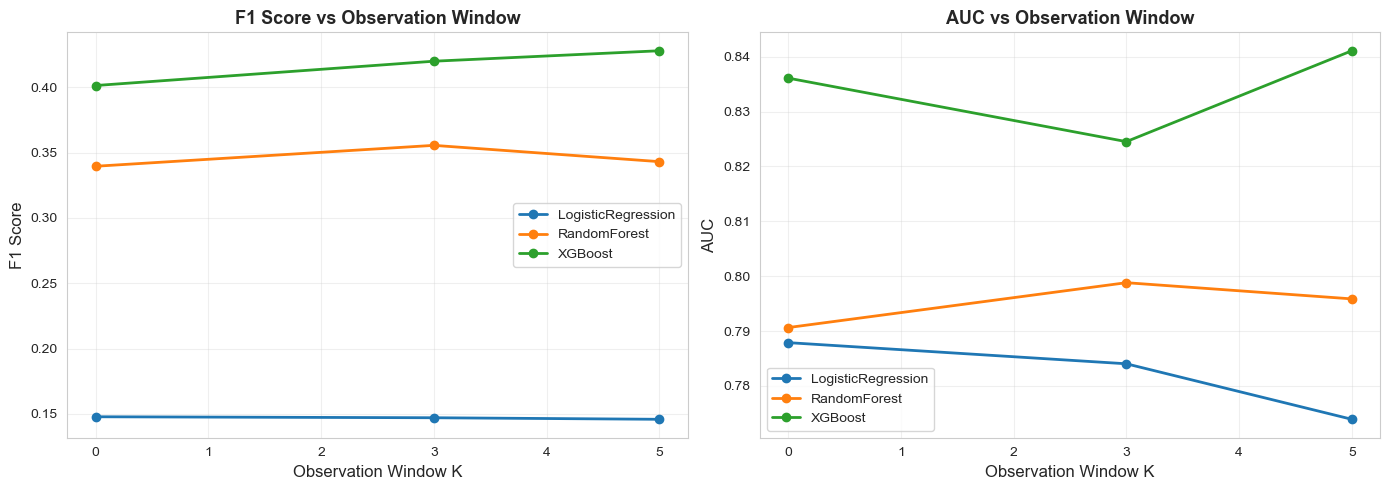

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
for model_name in models_config.keys():
    f1_scores = [results[model_name][K]['test']['f1'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
for model_name in models_config.keys():
    auc_scores = [results[model_name][K]['test']['auc'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()